In [1]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, path)

compute-e-16-230.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


# Prepare the data

In [2]:
f = h5py.File("./data/hdf5/1240k_v43/ch3.h5", "r") # Load for Sanity Check. See below!

In [8]:
%%time
cutoff=0.98
gps = f["calldata/GP"][:,:,:]
m = np.max(gps, axis=2)
idx = (m>cutoff)

CPU times: user 48.7 s, sys: 12.6 s, total: 1min 1s
Wall time: 1min


In [9]:
%%time
gts = f["calldata/GT"][:,:,:]
gt = np.sum(gts, axis=2)
gt[~idx]=1 # Set low quality data to heterozygotes

CPU times: user 14.5 s, sys: 3.51 s, total: 18 s
Wall time: 18 s


In [10]:
### Figure out the wacky indiviuals
m_ind = np.mean(idx, axis=0)
idx_iid = (m_ind>0.5)

In [11]:
samples1 = f["samples"][idx_iid]
m_ind1 = m_ind[idx_iid] # Average for the good Individuals
gt1 = gt[:,idx_iid]  # Takes the longest time
idx1 = idx[:,idx_iid] # Get the index of good loci
print(f"Extracted {len(samples1)} Samples with good enough coverage")

Extracted 9813 Samples with good enough coverage


In [12]:
%%time
homo = (gt1 == 0)
homo2 = (gt1 == 2)

CPU times: user 696 ms, sys: 291 ms, total: 987 ms
Wall time: 984 ms


In [95]:
%%time
i=0
opp_homo = (homo[:,i][:,None] & homo2[:,:]) | (homo2[:,i][:,None] & homo[:,:])
good_loci = idx1[:,i][:,None] & idx1[:,:] # Both Loci there

opp_homo_ind = np.sum(opp_homo, axis=0)
o_homo_fracs = opp_homo_ind / np.sum(good_loci, axis=0)

CPU times: user 1.18 s, sys: 666 ms, total: 1.85 s
Wall time: 1.85 s


### Create the sharing Matrix

In [13]:
n=np.shape(homo)[1]
frac_mat = -np.ones((n,n), dtype="float")  # Matrix of sharing

In [15]:
%%time

for i in range(500,2000):
    opp_homo = (homo[:,i][:,None] & homo2[:,:]) | (homo2[:,i][:,None] & homo[:,:]) # Opposing homozygotes
    good_loci = idx1[:,i][:,None] & idx1[:,:] # Both Loci good quality

    opp_homo_ind = np.sum(opp_homo, axis=0)
    o_homo_fracs = opp_homo_ind / np.sum(good_loci, axis=0)
    frac_mat[i,:] = o_homo_fracs

CPU times: user 27min 14s, sys: 14min 51s, total: 42min 6s
Wall time: 42min 6s


In [18]:
frac_mat[500,:]

array([0.06183872, 0.0694051 , 0.04488421, ..., 0.06739893, 0.06936955,
       0.07822146])

# Plot Figures

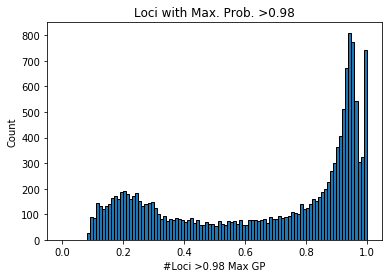

In [74]:
bins = np.linspace(0,1,101)

plt.figure()
ax = plt.gca()
ax.set_title("Loci with Max. Prob. >0.98")
ax.hist(m_ind, bins=bins, ec="k")
ax.set_ylabel("Count")
ax.set_xlabel("#Loci >0.98 Max GP")
plt.show()

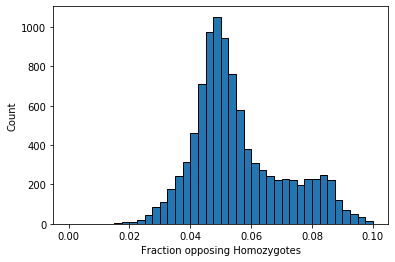

In [21]:
bins = np.linspace(0,0.1,41)

plt.figure()
ax = plt.gca()
ax.hist(frac_mat[600,:], bins=bins, ec="k")
ax.set_ylabel("Count")
ax.set_xlabel("Fraction opposing Homozygotes")
plt.show()

In [94]:
np.sum(frac_mat, axis=1)

array([    0,     0,     0, ..., -9813, -9813, -9813])

In [32]:
idx_pair = np.where((frac_mat[:,:]<0.001) & (frac_mat[:,:]>0))

In [33]:
df = pd.DataFrame({"iid1":samples1[idx_pair[0]], "iid2":samples1[idx_pair[1]],
                   "opp_homo_rate_ch3":frac_mat[idx_pair]})

In [34]:
df.to_csv("./output/dumpster/o_homo_500_1999.tsv", sep="\t", index=False)

In [36]:
df[:50]

,iid1,iid2,opp_homo_rate_ch3
0,Mezmaiskaya.SG,Spy_final_provisional.SG,0.000798
1,Brillenhohle,Darra.I.Kur_d,0.000940
2,I1051,RISE683.SG,0.000029
3,I1657,I1658,0.000083
4,I1658,I1657,0.000083
5,I1637,I1636,0.000276
6,I1636,I1637,0.000276
7,I1732,Ukraine_N1.SG,0.000072
8,RISE483.SG,Darra.I.Kur_d,0.000655
9,I1166,I1169,0.000157


In [154]:
9813/100 * 2

196.26